Epoch 1 = Training Loss = 1.4499399512261153, Validation Loss = 0.7961860095709562 , accuracy = 0.6160833333333333
Epoch 2 = Training Loss = 0.6229581065382809, Validation Loss = 0.511050983145833 , accuracy = 0.8308125
Epoch 3 = Training Loss = 0.4595857973396778, Validation Loss = 0.4146450890228152 , accuracy = 0.872
Epoch 4 = Training Loss = 0.39133386315312235, Validation Loss = 0.36528591671958566 , accuracy = 0.8881041666666667
Epoch 5 = Training Loss = 0.3532046333653852, Validation Loss = 0.33646576672792433 , accuracy = 0.8971458333333333
Epoch 6 = Training Loss = 0.3268792315130122, Validation Loss = 0.314619278665632 , accuracy = 0.9043333333333333
Epoch 7 = Training Loss = 0.3064556188730057, Validation Loss = 0.29668536512181165 , accuracy = 0.9098541666666666
Epoch 8 = Training Loss = 0.2892921214643866, Validation Loss = 0.2812642138404772 , accuracy = 0.9145625
Epoch 9 = Training Loss = 0.27508308575488627, Validation Loss = 0.26843773171305657 , accuracy = 0.919229166

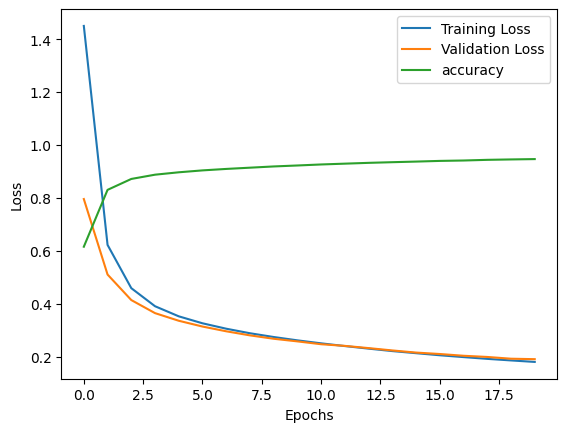

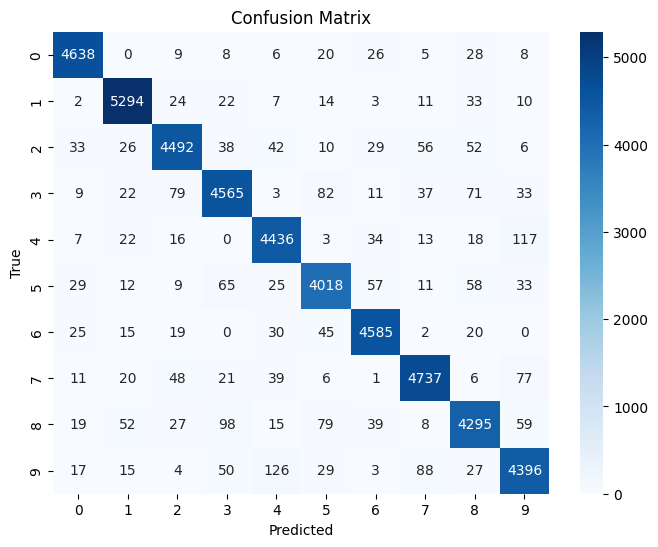

In [50]:
import numpy as np
import torch
from torch import nn
import torchvision.datasets as raw_dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class ClassificationModel(nn.Module):
    def __init__(self, input, hidden1, hidden2, hidden3,hidden4 ,output):
        super(ClassificationModel, self).__init__()
        self.W1 = torch.randn(input, hidden1, requires_grad=True)
        self.b1 = torch.randn(hidden1, requires_grad=True)
        self.W2 = torch.randn(hidden1, hidden2, requires_grad=True)
        self.b2 = torch.randn(hidden2, requires_grad=True)
        self.W3 = torch.randn(hidden2, hidden3, requires_grad=True)
        self.b3 = torch.randn(hidden3, requires_grad=True)
        self.W4 = torch.randn(hidden3, hidden4,requires_grad=True)
        self.b4 = torch.randn(hidden4, requires_grad=True)
        # self.W5 = torch.randn(hidden4, hidden5,requires_grad=True)
        # self.b5 = torch.randn(hidden5, requires_grad=True)
        self.W6 = torch.randn(hidden4, output, requires_grad=True)
        self.b6 = torch.randn(output, requires_grad=True)


        torch.nn.init.xavier_normal_(self.W1)
        torch.nn.init.xavier_normal_(self.W2)
        torch.nn.init.xavier_normal_(self.W3)
        torch.nn.init.xavier_normal_(self.W4)
        # torch.nn.init.xavier_normal_(self.W5)
        torch.nn.init.xavier_normal_(self.W6)

    def forward(self, X):
      HLayer1 = torch.mm(X, self.W1) + self.b1
      HLayer1 = torch.relu(HLayer1)
      HLayer2 = torch.mm(HLayer1, self.W2) + self.b2
      HLayer2 = torch.relu(HLayer2)
      HLayer3 = torch.mm(HLayer2, self.W3) + self.b3
      HLayer3 = torch.relu(HLayer3)
      HLayer4 = torch.mm(HLayer3,self.W4) + self.b4
      HLayer4 = torch.relu(HLayer4)
      # HLayer5 = torch.mm(HLayer4,self.W5) + self.b5
      # HLayer5 = torch.relu(HLayer5)
      output = torch.mm(HLayer4, self.W6) + self.b6

      return output

data = raw_dataset.MNIST(root="./data", train=True, download=True)

x_data  = np.array(data.data)
y_data = np.array(data.targets)

x_data = x_data.reshape(x_data.shape[0], -1)

x_data = x_data / 255.0
x_data = (x_data - 0.5) / 0.5

train_data = torch.tensor(x_data,dtype=torch.float32)
test_data = torch.tensor(y_data,dtype=torch.long)

x_train, x_test, y_train, y_test = train_test_split(train_data, test_data, test_size=0.2, random_state=42)

Train = TensorDataset(x_train, y_train)
Test = TensorDataset(x_test, y_test)

BatchSize= 30
epochs = 20

Train_loader = DataLoader(dataset= Train, batch_size=BatchSize, shuffle=True)
Test_loader = DataLoader(dataset= Test, batch_size=BatchSize, shuffle=True)
Epoch_Losses = []
val_losses = []
accuracies = []

input = 784
h1,h2,h3,h4 = 180,140,100,60
output=10
model = ClassificationModel(input,h1,h2,h3,h4,output)
lossFunction = nn.CrossEntropyLoss()
optimizer = optim.SGD([model.W1,model.b1,model.W2,model.b2,model.W3,model.b3,model.W4,model.b4,model.W6,model.b6], lr=0.001)

for epoch in range(epochs):
  batch_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []
  for x_batch, y_batch in Train_loader:
        model.train()
        yhat = model(x_batch)
        loss = lossFunction(yhat, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()

        _, predicted = torch.max(yhat, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

  batch_loss /= len(Train_loader)
  Epoch_Losses.append(batch_loss)

  accuracy = correct / total
  accuracies.append(accuracy)


  model.eval()
  val_loss= 0
  with torch.no_grad():
    for x_batch, y_batch in Test_loader:
      yhat = model(x_batch)
      loss = lossFunction(yhat, y_batch)
      val_loss += loss.item()

  val_loss /= len(Test_loader)
  val_losses.append(val_loss)

  print(f"Epoch {epoch+1} = Training Loss = {batch_loss}, Validation Loss = {val_loss} , accuracy = {accuracy}")


plt.plot(Epoch_Losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.plot(accuracies,label="accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
